# Import das bibliotecas

In [310]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Leitura dos dados

In [311]:
data_training = pd.read_csv('falencia-treinamento.csv', delimiter=';')
data_test = pd.read_csv('falencia-teste.csv', delimiter=';')
data_result = pd.read_csv('modelo-submissao.csv', delimiter=';')

# Divisão do conjunto de dados

In [312]:
# Divisão do conjunto de dados falencia-treinamento em dados de treinamento e dados de teste. Divisão de 70% treinamento e 30% testes
X_train, X_test, y_train, y_test = train_test_split(data_training.drop('Resultado', axis=1), data_training['Resultado'], test_size=0.3, random_state=42)

# Técnica Smote

In [319]:
# Técnica SMOTE para aplicar o Oversampling (criação de cópias da classe minoritária para que as classes fiquem equilibradas)
smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Seleção Univariada

In [321]:
selector = SelectKBest(chi2, k=15)
X_new = selector.fit_transform(X_train_resampled, y_train_resampled)

# Obtém os índices dos recursos selecionados
selected_features = selector.get_support()

# Obtém os nomes dos recursos selecionados
selected_feature_names = X_train.columns[selected_features]

# Substitui as variáveis X_train e X_test pelos recursos selecionados
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Regressão Logística

In [322]:
def logistic_regression():
    # Cria um modelo de regressão logística
    logistic_model = LogisticRegression(max_iter=500)
    
    # Ajusta o modelo aos dados de treinamento
    logistic_model.fit(X_train_selected, y_train)
    
    # Faz previsões nos dados de teste
    y_pred_lr = logistic_model.predict(X_test_selected)

    # Calcula a acurácia do modelo nos dados de teste extraído dos de treinamento
    accuracy = accuracy_score(y_test, y_pred_lr)
    f_measure = f1_score(y_test, y_pred_lr)

    # Exibe os resultados
    print("Regressão Logística")
    print(f"Acurácia: {accuracy}")
    print(f"F-measure: {f_measure}")

# Árvore de Decisão

In [323]:
def decision_tree():
    # Cria um modelo de árvore de decisão com profundidade máxima de 3
    tree_model = DecisionTreeClassifier(max_depth=3)

    # Ajusta o modelo aos dados de treinamento
    tree_model.fit(X_train_selected, y_train)

    # Faz previsões nos dados de teste
    y_pred_dt = tree_model.predict(X_test_selected)

    # Calcula a acurácia e f-measure do modelo nos dados de teste
    accuracy = accuracy_score(y_test, y_pred_dt)
    f_measure = f1_score(y_test, y_pred_dt)

    # Exibe os resultados
    print('\nÁrvore de Decisão')
    print(f"Acurácia: {accuracy}")
    print(f"F-measure: {f_measure}")

# Random Forest

In [324]:
def random_forest():
    # Cria um modelo de Random Forest com 100 árvores de decisão
    rf_model = RandomForestClassifier(n_estimators=100)

    # Ajusta o modelo aos dados de treinamento
    rf_model.fit(X_train_selected, y_train)

    # Faz previsões nos dados de teste
    y_pred_rf = rf_model.predict(X_test_selected)

    # Calcula a acurácia e f-measure do modelo nos dados de teste
    accuracy = accuracy_score(y_test, y_pred_rf)
    f_measure = f1_score(y_test, y_pred_rf)

    # Exibe os resultados
    print('\nRandom Forest')
    print(f"Acurácia: {accuracy}")
    print(f"F-measure: {f_measure}")

# Resultados

In [325]:
logistic_regression()
decision_tree()
random_forest()

Regressão Logística
Acurácia: 0.75
F-measure: 0.4642857142857143

Árvore de Decisão
Acurácia: 0.7833333333333333
F-measure: 0.5666666666666667

Random Forest
Acurácia: 0.7916666666666666
F-measure: 0.6376811594202899


# Comparação entre os modelos

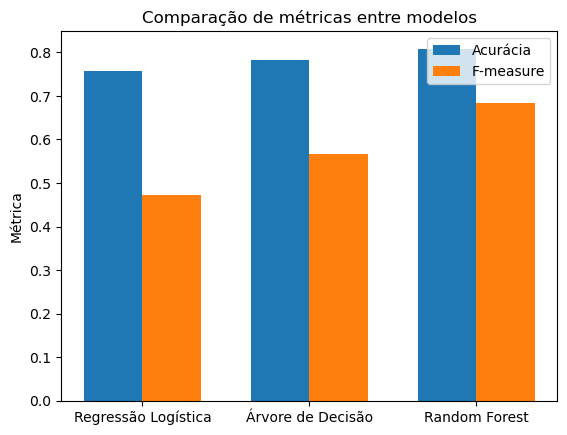

In [309]:
# definir os rótulos do eixo x e os valores do eixo y
labels = ['Regressão Logística', 'Árvore de Decisão', 'Random Forest']
accuracy_values = [accuracy_lr, accuracy_dt, accuracy_rf]
f_measure_values = [f_measure_lr, f_measure_dt, f_measure_rf]

# definir a largura das barras
bar_width = 0.35

# definir a posição das barras no eixo x
x = np.arange(len(labels))

# criar o gráfico de barras
fig, ax = plt.subplots()
rects1 = ax.bar(x - bar_width/2, accuracy_values, bar_width, label='Acurácia')
rects2 = ax.bar(x + bar_width/2, f_measure_values, bar_width, label='F-measure')

# adicionar rótulos, títulos e legendas ao gráfico
ax.set_ylabel('Métrica')
ax.set_title('Comparação de métricas entre modelos')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# exibir o gráfico
plt.show()